In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from os.path import basename

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [basename(item) for item in sorted(glob("../../../data/dog_images/train/*"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [27]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import urllib.request
with urllib.request.urlopen('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz') as f:
    open('bottleneck_features/DogVGG19Data.npz', 'wb').write(f.read())

In [28]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

In [29]:
train_VGG19.shape

(6680, 7, 7, 512)

In [30]:
### TODO: Define your architecture.

my_model = Sequential()
my_model.add(Dense(133, input_shape=train_VGG19.shape[1:]))
my_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
my_model.add(Dense(133, activation='softmax'))

my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7, 7, 133)         68229     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 133)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               17822     
Total params: 86,051
Trainable params: 86,051
Non-trainable params: 0
_________________________________________________________________


# Compile the Model

In [31]:
### TODO: Compile the model.
my_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [32]:
my_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.my.hdf5', 
                               verbose=1, save_best_only=True)

### TODO: Train the model.
my_model.fit(train_VGG19, train_targets,
             validation_data=(valid_VGG19, valid_targets),
             epochs=20,
             batch_size=20,
             callbacks=[my_checkpointer],
             verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 358us/step - loss: 9.0473 - acc: 0.2578 - val_loss: 5.4233 - val_acc: 0.4251
Epoch 2/20
6680/6680 [==============================] - 2s 317us/step - loss: 3.9004 - acc: 0.5633 - val_loss: 3.6990 - val_acc: 0.5545
Epoch 3/20
6680/6680 [==============================] - 2s 293us/step - loss: 2.7121 - acc: 0.6949 - val_loss: 3.4320 - val_acc: 0.6240
Epoch 4/20
6680/6680 [==============================] - 2s 289us/step - loss: 2.2228 - acc: 0.7472 - val_loss: 2.9759 - val_acc: 0.6455
Epoch 5/20
6680/6680 [==============================] - 2s 295us/step - loss: 1.9845 - acc: 0.7912 - val_loss: 3.2949 - val_acc: 0.6479
Epoch 6/20
6680/6680 [==============================] - 2s 286us/step - loss: 1.8315 - acc: 0.8171 - val_loss: 3.1926 - val_acc: 0.6455
Epoch 7/20
6680/6680 [==============================] - 2s 286us/step - loss: 1.6537 - acc: 0.8349 - val_loss: 3.3043 - val_acc: 0.6323
E

### Load the Model with the Best Validation Loss

In [33]:
### TODO: Load the model weights with the best validation loss.
my_model.load_weights('saved_models/weights.best.my.hdf5')

### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [34]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
my_predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(my_predictions)==np.argmax(test_targets, axis=1))/len(my_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 68.3014%


In [35]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def my_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = my_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

------------------------------------------------------------
images/Welsh_springer_spaniel_08203.jpg


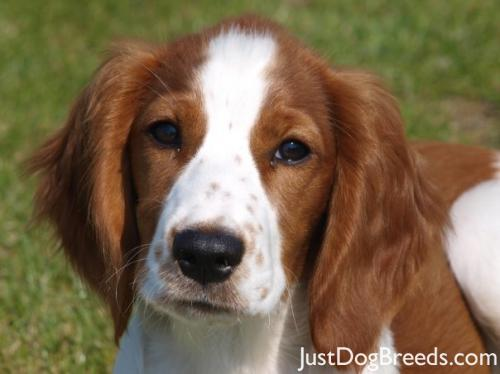

80142336/80134624 [==============================] - 1s 0us/step
This dog is a 130.Welsh_springer_spaniel
------------------------------------------------------------
images/sample_human_output.png


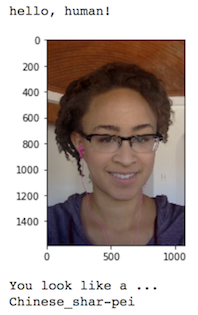

This person resembles a 018.Beauceron
------------------------------------------------------------
images/Labrador_retriever_06457.jpg


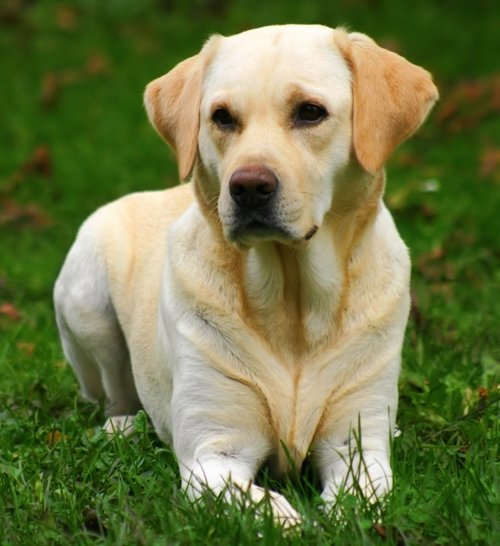

This dog is a 096.Labrador_retriever
------------------------------------------------------------
images/Curly-coated_retriever_03896.jpg


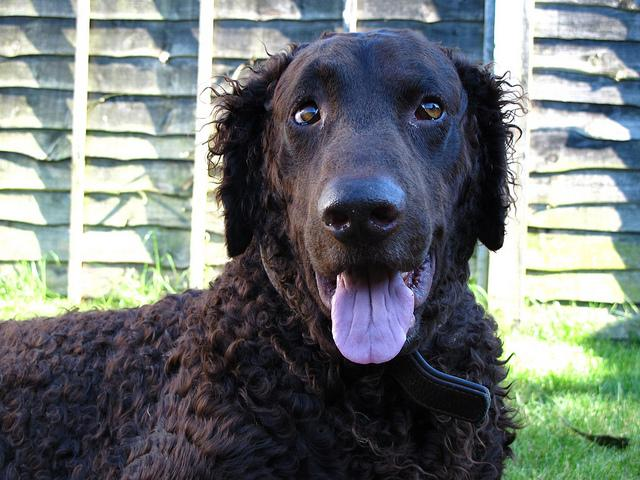

This dog is a 055.Curly-coated_retriever
------------------------------------------------------------
images/sample_cnn.png


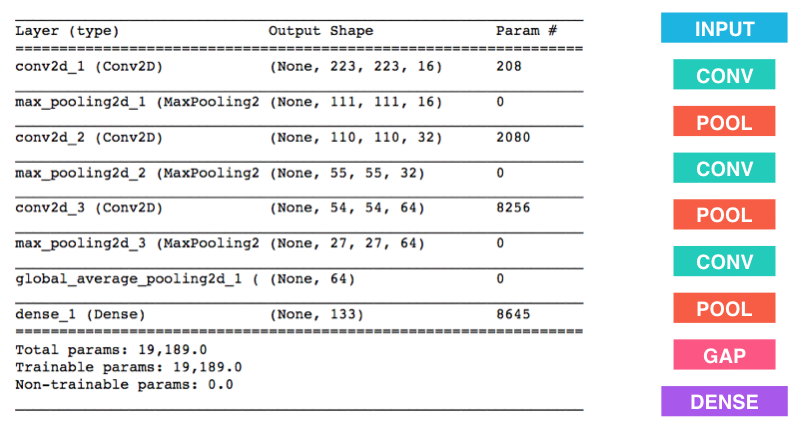

Neither a dog nor a human face detected in this picture
------------------------------------------------------------
images/Brittany_02625.jpg


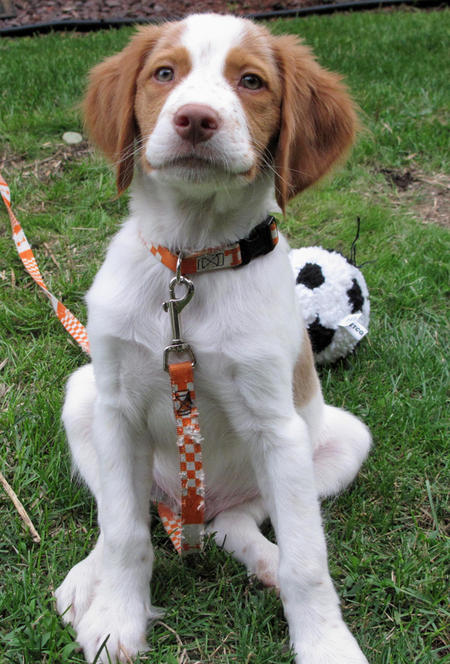

This dog is a 037.Brittany
------------------------------------------------------------
images/sample_human_2.png


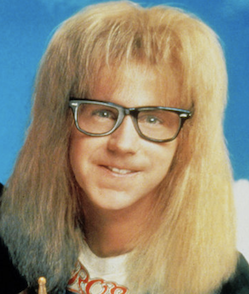

This person resembles a 111.Norwich_terrier
------------------------------------------------------------
images/Labrador_retriever_06449.jpg


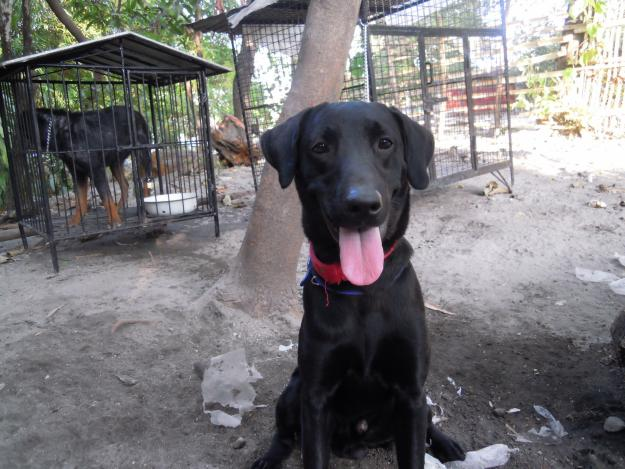

This dog is a 068.Flat-coated_retriever
------------------------------------------------------------
images/American_water_spaniel_00648.jpg


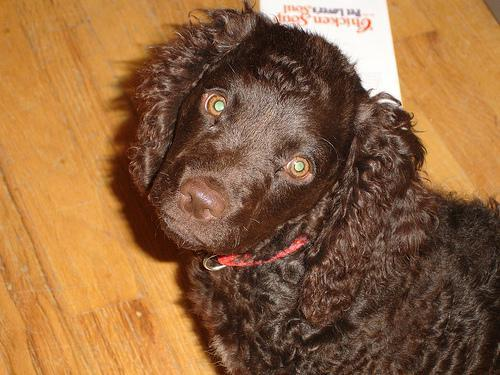

This dog is a 009.American_water_spaniel
------------------------------------------------------------
images/sample_dog_output.png


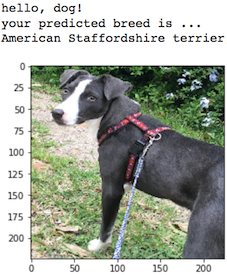

Neither a dog nor a human face detected in this picture
------------------------------------------------------------
images/Labrador_retriever_06455.jpg


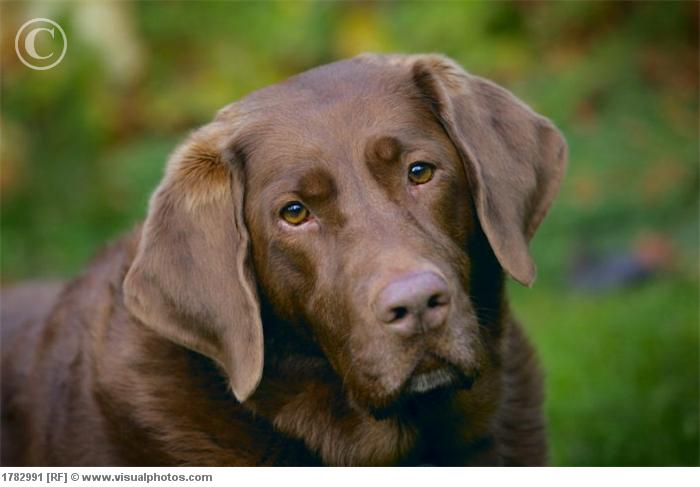

This dog is a 068.Flat-coated_retriever


In [37]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
from IPython.display import Image

for item in glob('images/*'):
    print('-' * 60 + '\n' + item)
    display(Image(filename=item, width=100))
    print(which_breed(item))

------------------------------------------------------------
my_images/Fox Terrier Wikipedia.jpg


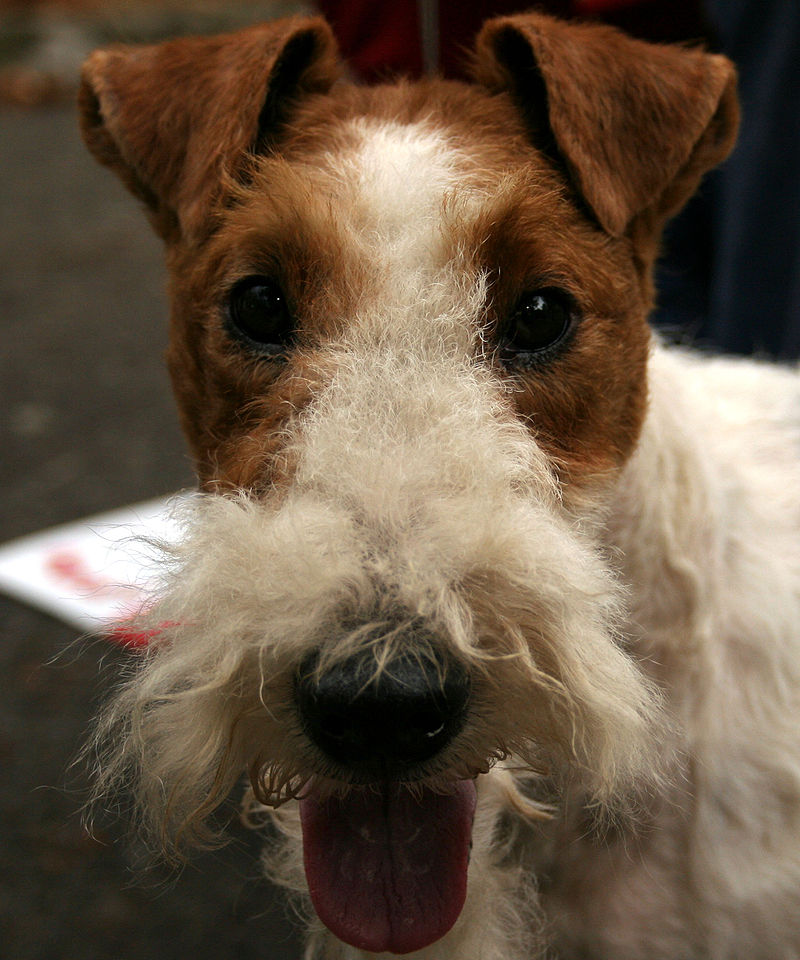

This dog is a 104.Miniature_schnauzer
------------------------------------------------------------
my_images/Maltese Drawing Wikihow.jpg


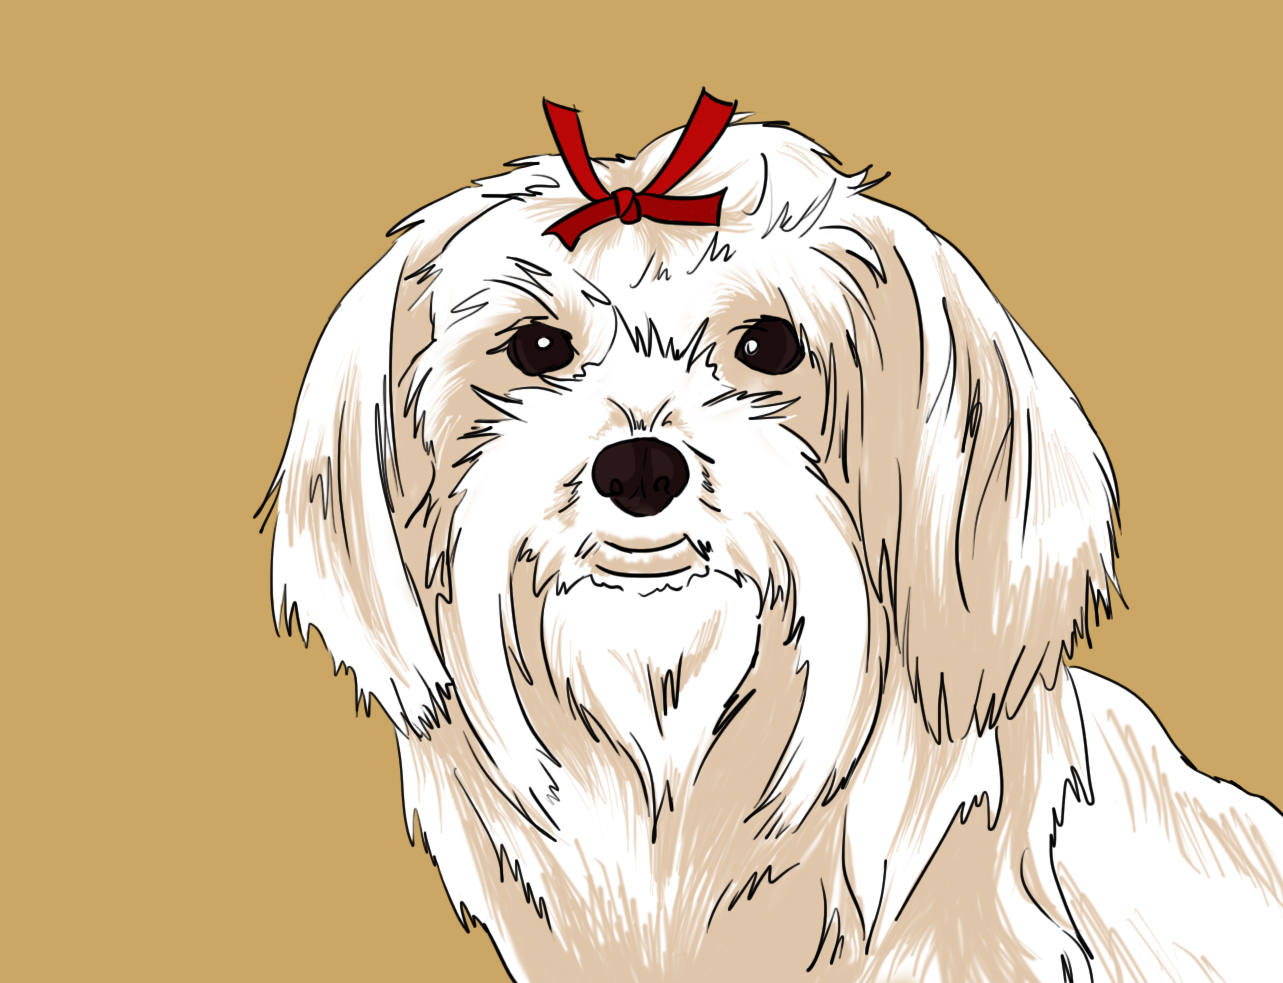

This dog is a 101.Maltese
------------------------------------------------------------
my_images/Cat Wikipedia.jpg


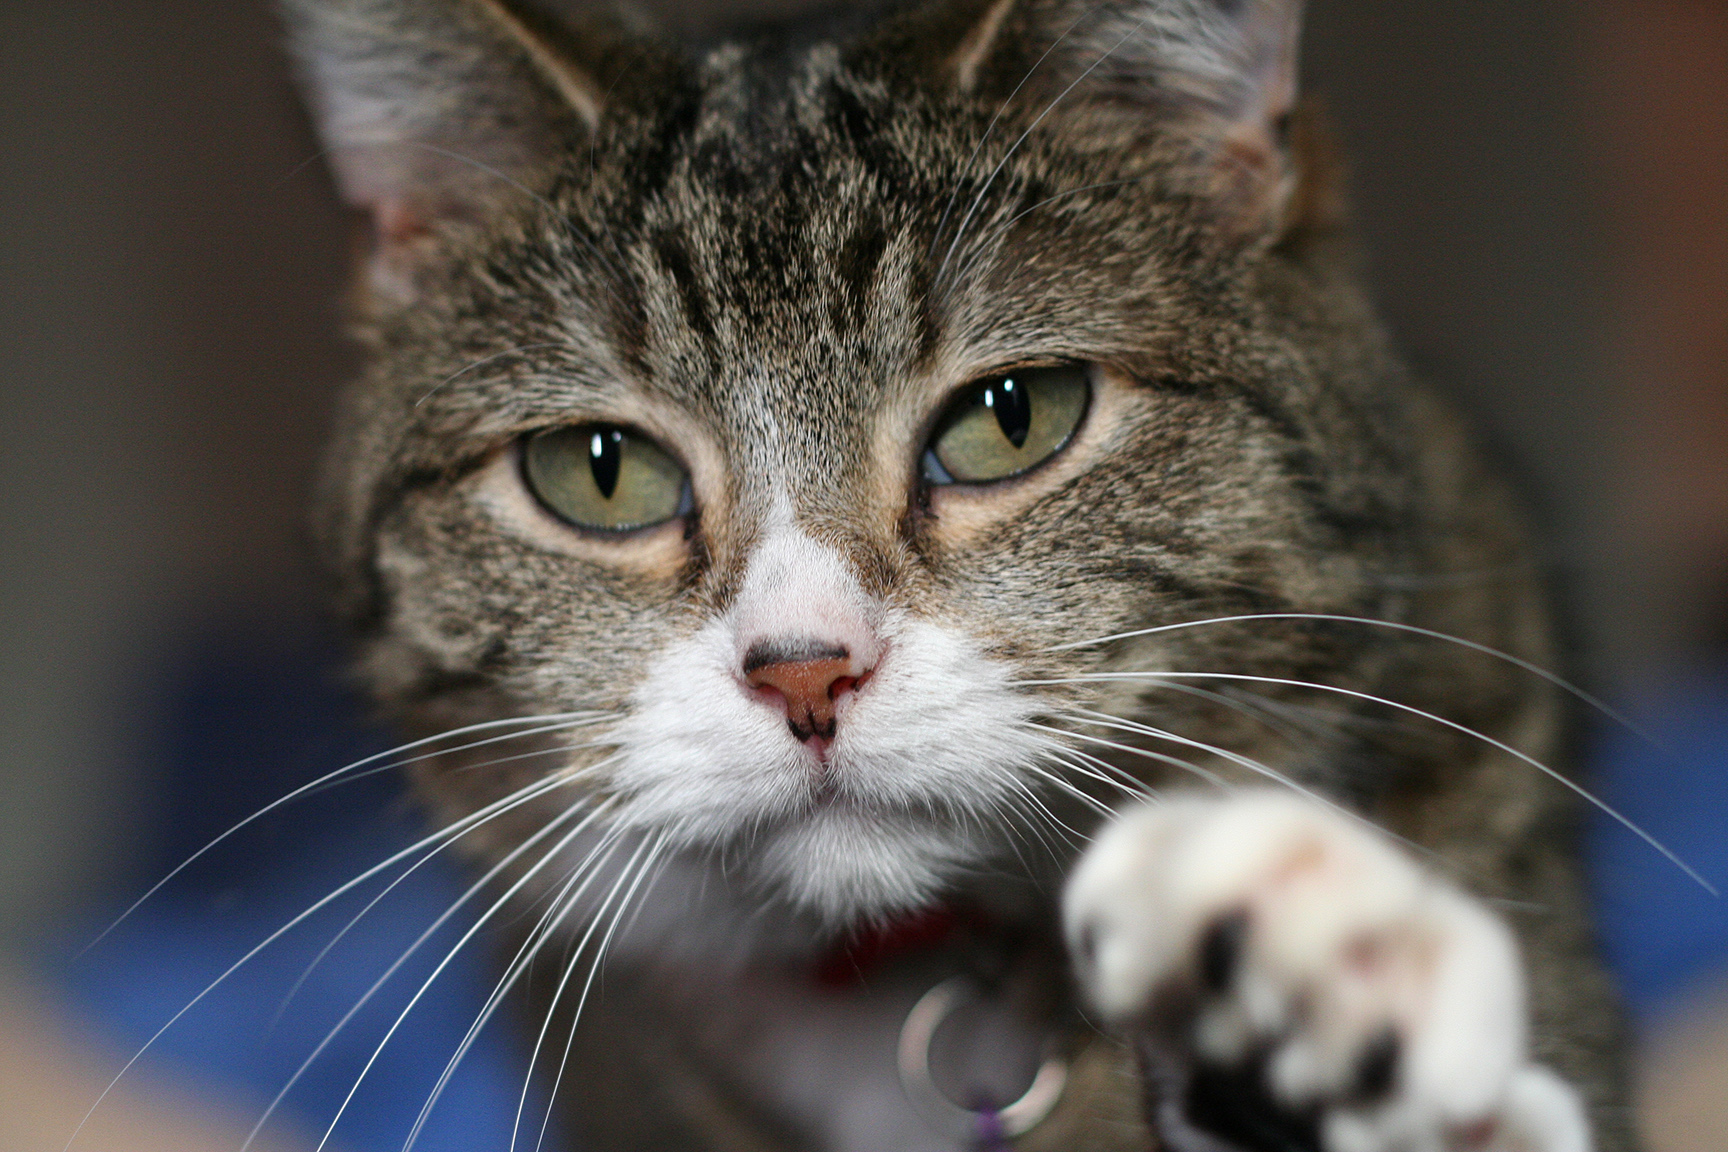

Neither a dog nor a human face detected in this picture
------------------------------------------------------------
my_images/Toy_Fox_Terrier_body Wikipedia.jpg


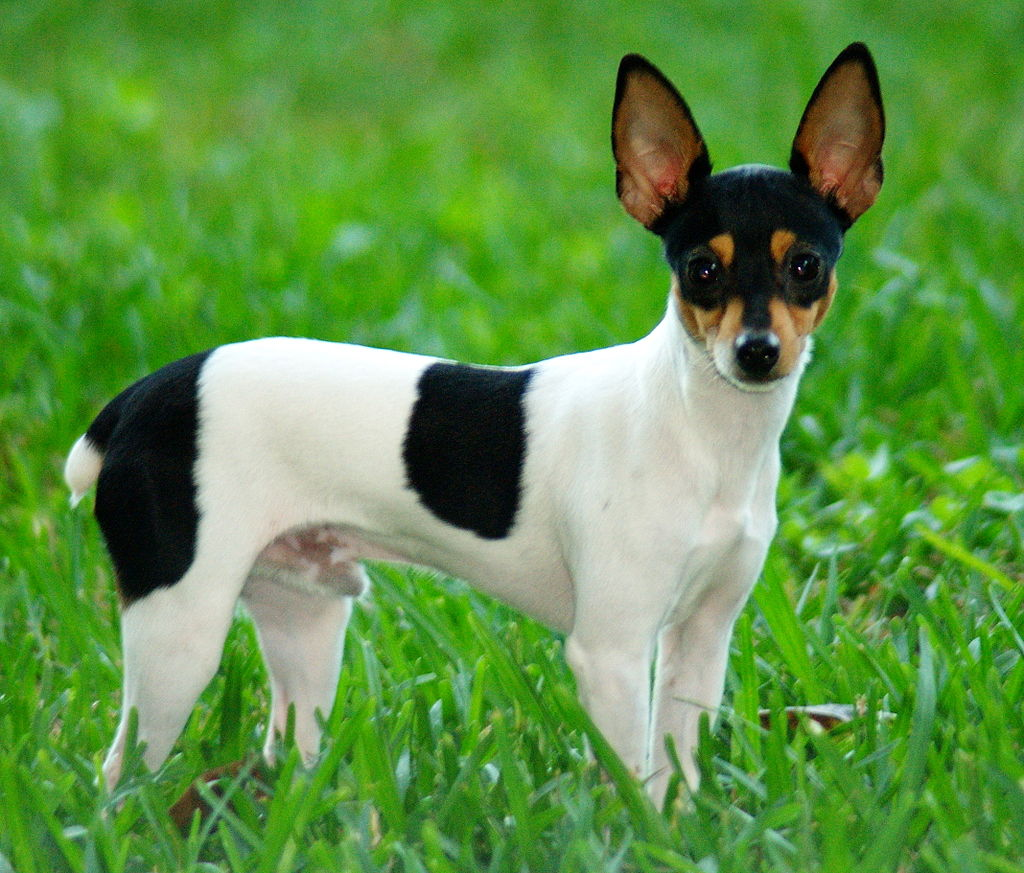

This dog is a 048.Chihuahua
------------------------------------------------------------
my_images/Dalmatian Wikipedia.jpg


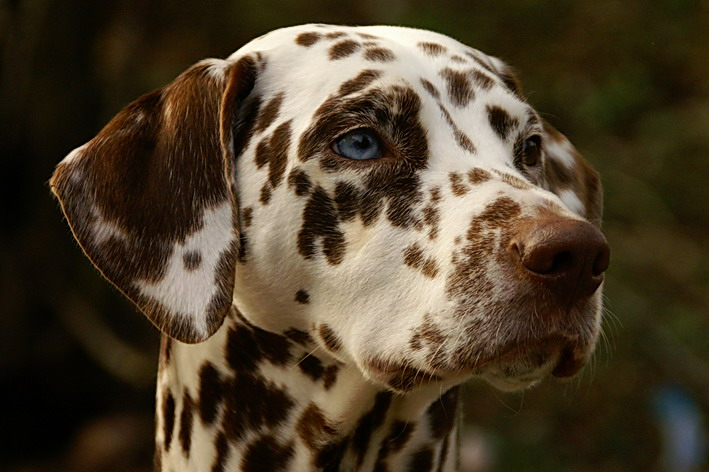

This dog is a 057.Dalmatian
------------------------------------------------------------
my_images/alana2.jpg


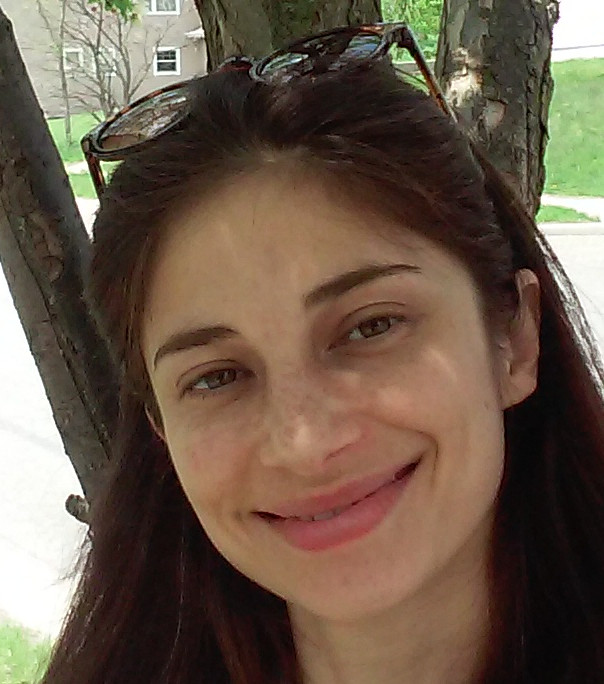

This person resembles a 090.Italian_greyhound
------------------------------------------------------------
my_images/augusto.jpg


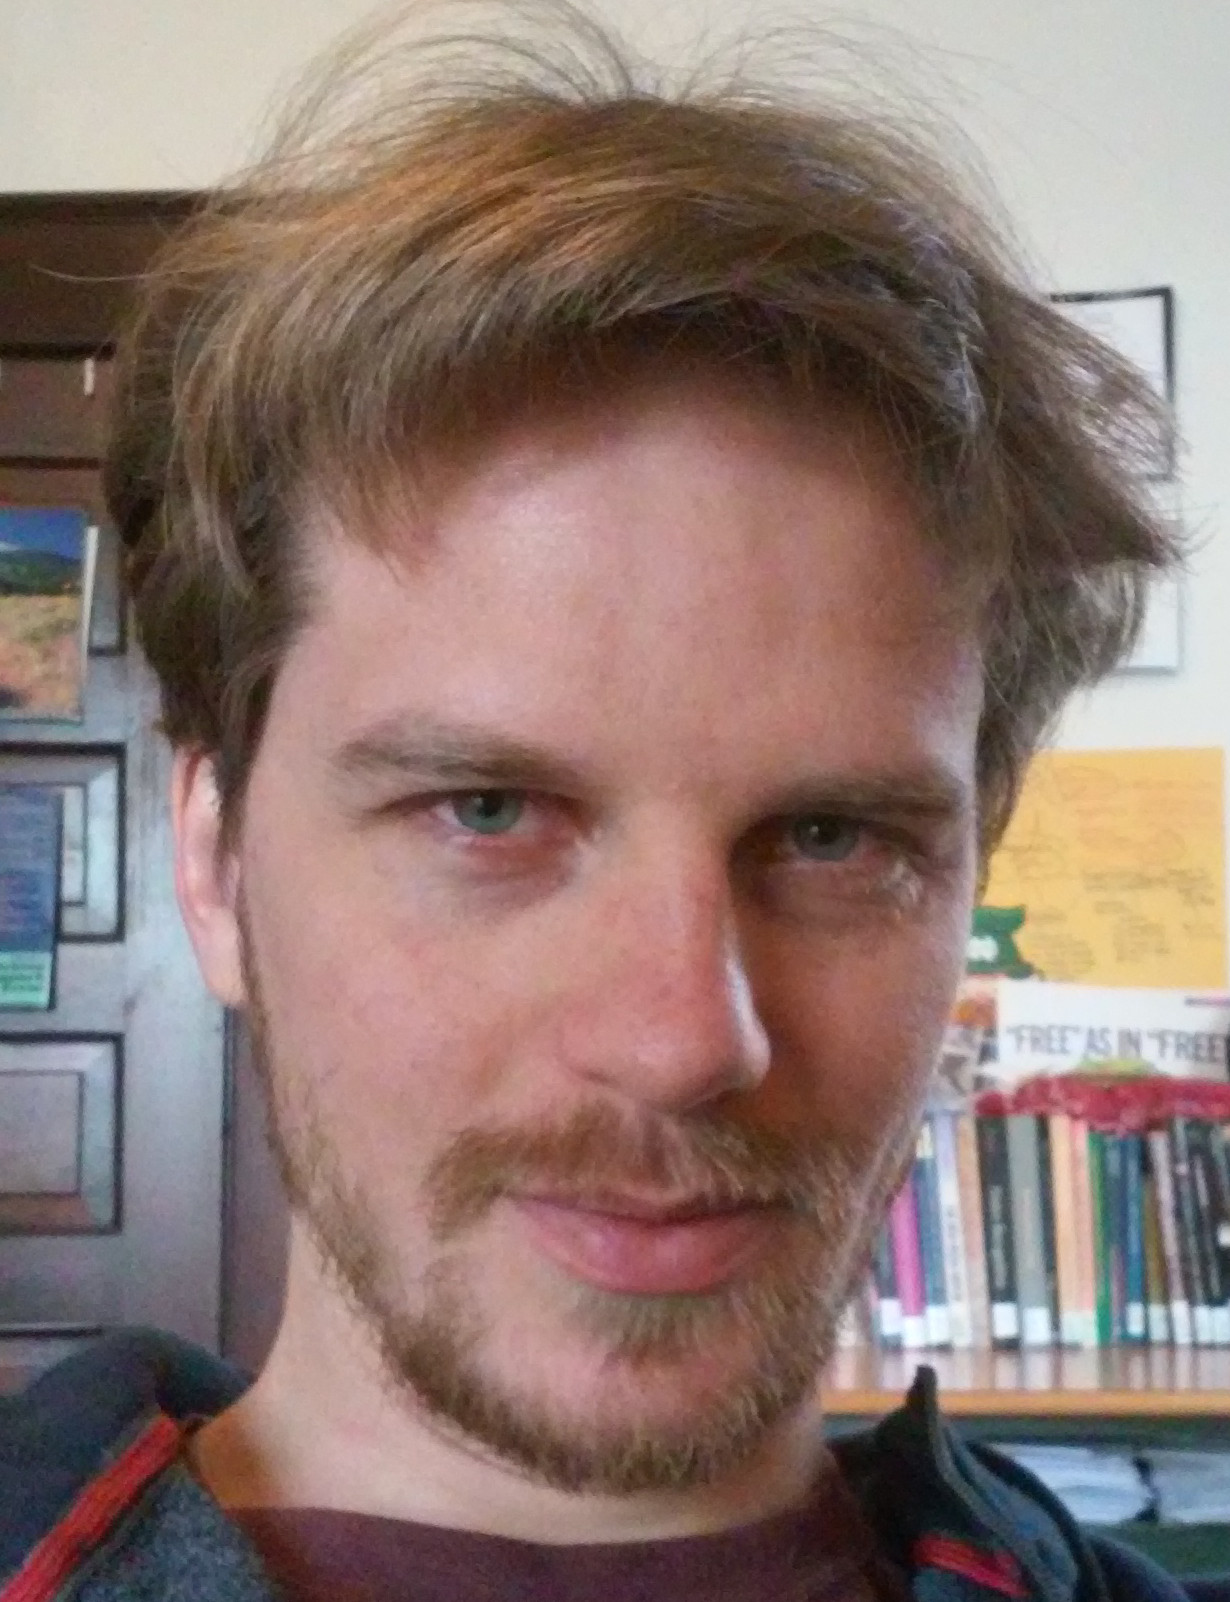

This person resembles a 088.Irish_water_spaniel
------------------------------------------------------------
my_images/augusto2.jpg


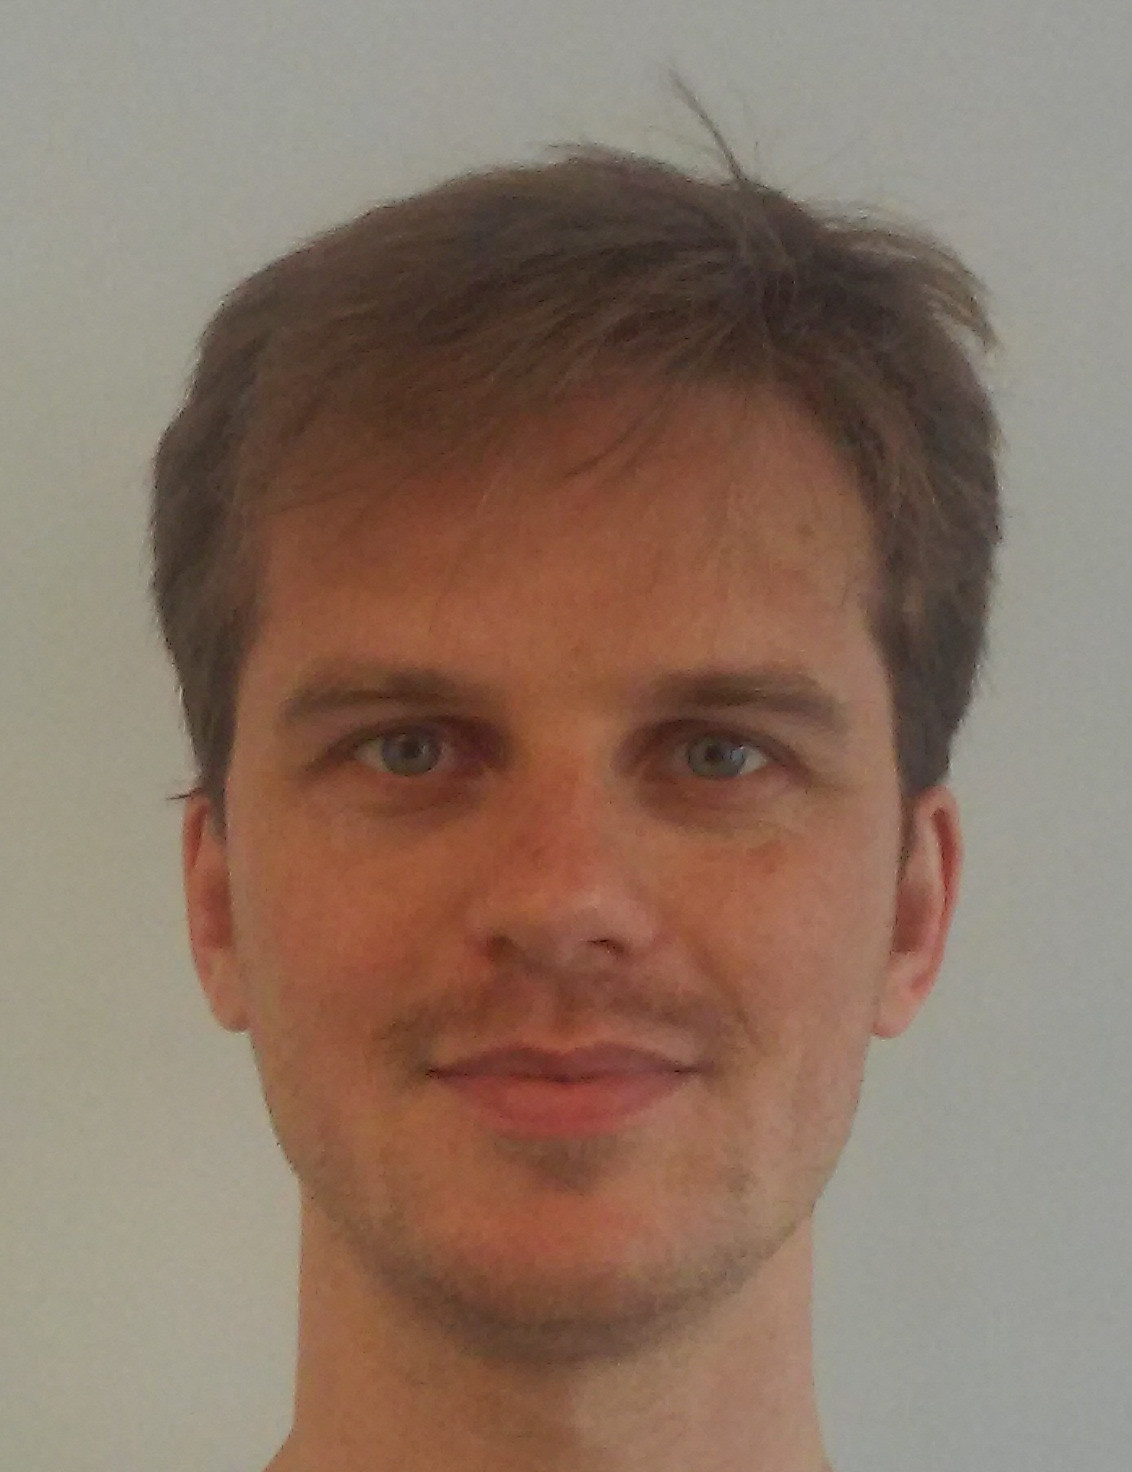

This person resembles a 127.Silky_terrier
------------------------------------------------------------
my_images/abel.jpg


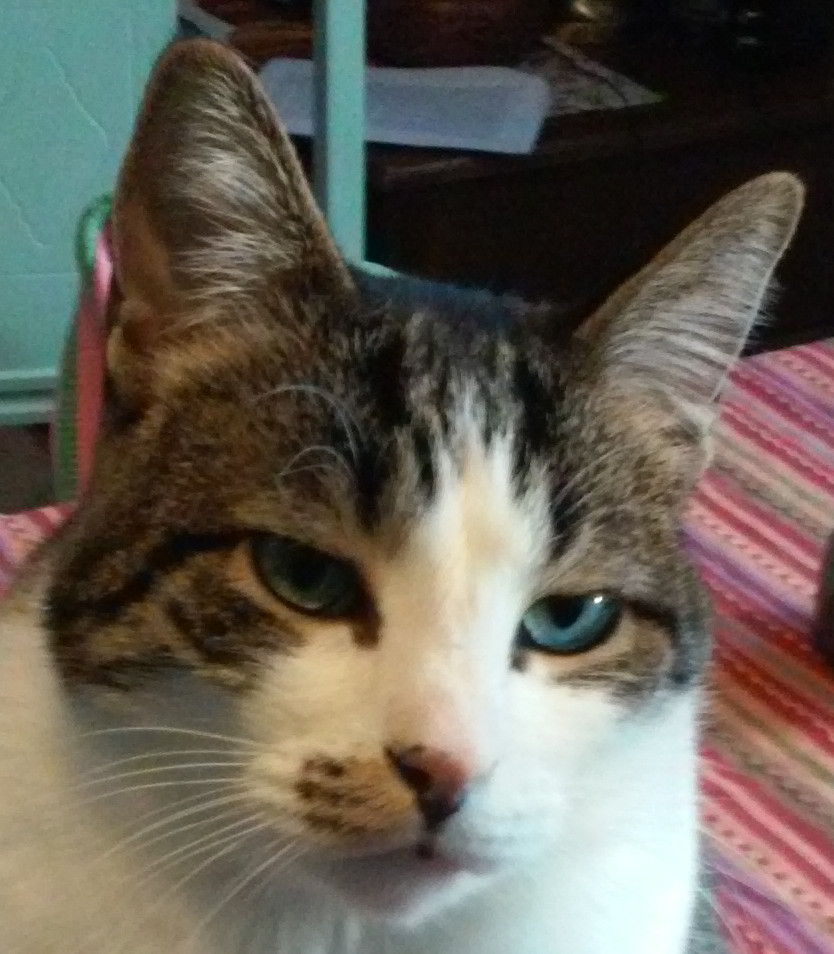

Neither a dog nor a human face detected in this picture
------------------------------------------------------------
my_images/alana.jpg


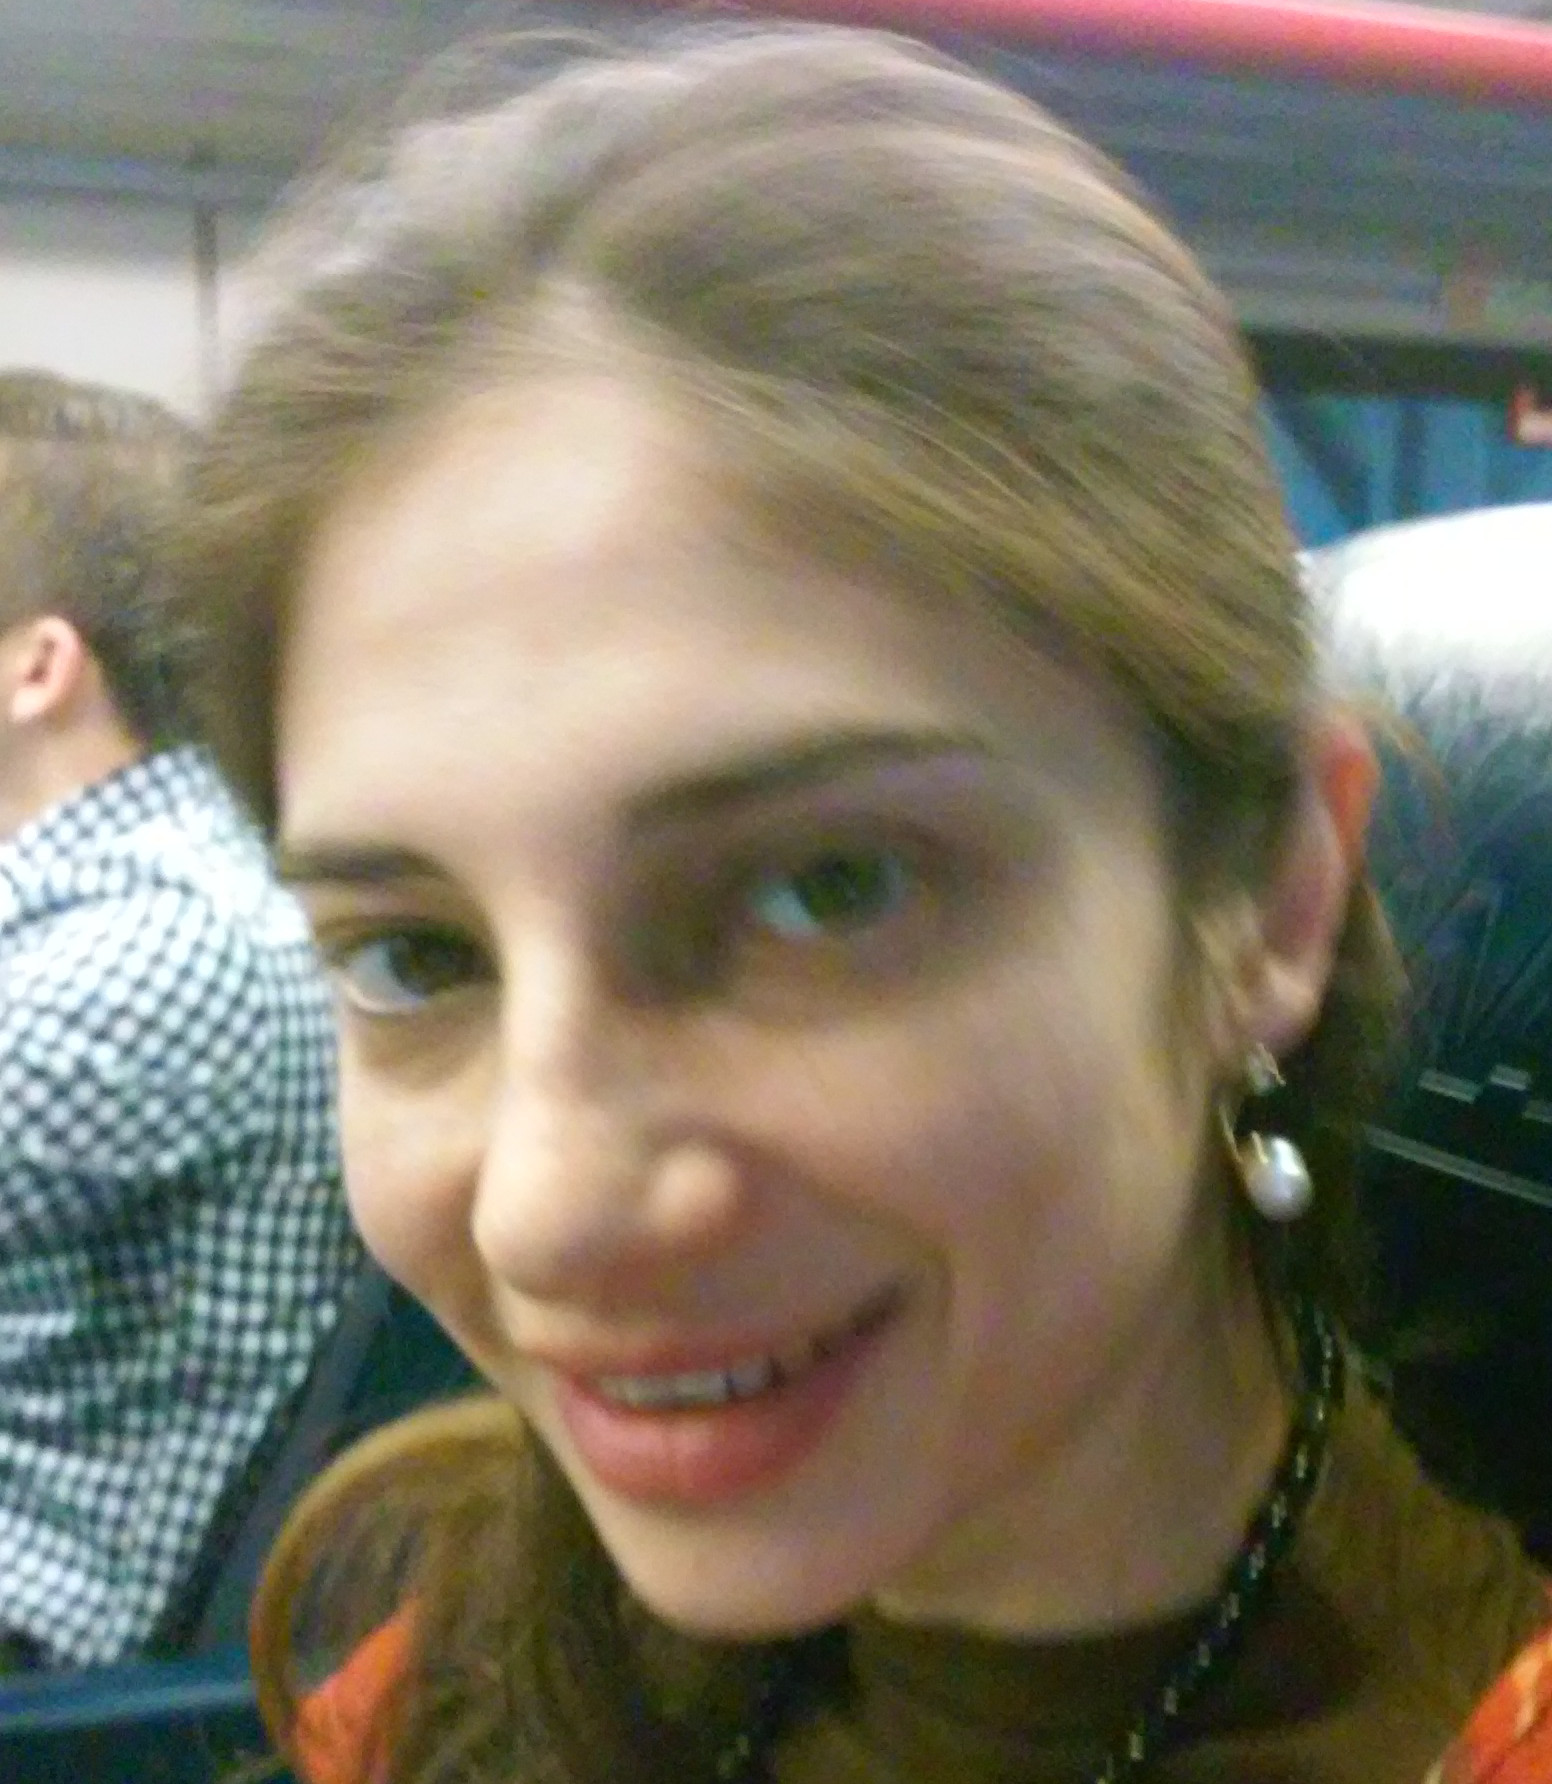

This person resembles a 127.Silky_terrier


In [38]:
for item in glob('my_images/*'):
    print('-' * 60 + '\n' + item)
    display(Image(filename=item, width=100))
    print(which_breed(item))